# BOOTSTRAP BONDS TO CREATE A ZERO CURVE

In this notebook I show how you can exactly refit the implied zero curve from bond prices using a piecewise flat curve.

In [1]:
import datetime as dt
import pandas as pd

In [2]:
from financepy.utils import *
from financepy.products.bonds import *
from financepy.market.curves import *

## Load Bond Data

I have downloaded some bond price data from the UK DMO

In [3]:
# Move into the local folder of notebook
%pwd
%cd notebooks/products/bonds/
%pwd

[WinError 3] The system cannot find the path specified: 'notebooks/products/bonds/'
C:\Users\domok\Dropbox\Desktop\RESEARCH_DB\FinancePy\Code\financepy-git\notebooks\products\bonds


'C:\\Users\\domok\\Dropbox\\Desktop\\RESEARCH_DB\\FinancePy\\Code\\financepy-git\\notebooks\\products\\bonds'

In [4]:
bond_dataframe = pd.read_csv('./data/giltbondprices.txt', sep='\t')

We'll use mid-market prices for our analysis

In [5]:
bond_dataframe['mid'] = 0.5*(bond_dataframe['bid'] + bond_dataframe['ask'])

We need to use UK bond conventions

In [6]:
dc_type, freq_type, settle_days, spot_days, cal = \
get_bond_market_conventions(BondMarkets.UNITED_KINGDOM)

In [7]:
freq_type

<FrequencyTypes.SEMI_ANNUAL: 2>

In [8]:
today = Date(18,9,2012)
settle_dt = today.add_weekdays(settle_days)
print("Settles:", settle_dt)

Settles: 19-SEP-2012


In [9]:
bonds = []
clean_prices = []

In [10]:
for index, bondRow in bond_dataframe.iterrows():

    date_string = bondRow['maturity']
    mat_dt_time = dt.datetime.strptime(date_string, '%d-%b-%y')
    maturity_dt = from_datetime(mat_dt_time)
    issue_dt = Date(maturity_dt.d, maturity_dt.m, 2000)
    coupon = bondRow['coupon']/100.0
    bond = Bond(issue_dt, maturity_dt, coupon, freq_type, dc_type)
    clean_price = bondRow['mid']

    bonds.append(bond)
    clean_prices.append(clean_price)

## Bootstrapping the Bond Prices

We pass the bond prices and bonds and the bootstrap is done automatically

In [11]:
bondCurve = BondZeroCurve(settle_dt, bonds, clean_prices)

Let's just check that this curve reprices the bond

In [12]:
for clean_price, bond in zip(clean_prices,bonds):
    fittedPrice = bond.clean_price_from_discount_curve(settle_dt, bondCurve)
    diff = fittedPrice - clean_price
    print("Market: %10.6f   Fitted: %10.6f   Diff: %10.7f"% (clean_price,fittedPrice,diff))

Market: 101.995000   Fitted: 101.995000   Diff: -0.0000000
Market: 107.920000   Fitted: 107.920000   Diff: -0.0000002
Market: 102.975000   Fitted: 102.975000   Diff:  0.0000000
Market: 109.355000   Fitted: 109.355000   Diff: -0.0000000
Market: 105.625000   Fitted: 105.625000   Diff: -0.0000000
Market: 112.980000   Fitted: 112.979999   Diff: -0.0000008
Market: 124.470000   Fitted: 124.470000   Diff:  0.0000000
Market: 104.980000   Fitted: 104.980000   Diff:  0.0000000
Market: 113.495000   Fitted: 113.494999   Diff: -0.0000006
Market: 138.570000   Fitted: 138.570000   Diff: -0.0000000
Market: 121.790000   Fitted: 121.789999   Diff: -0.0000007
Market: 121.345000   Fitted: 121.345000   Diff: -0.0000000
Market: 116.815000   Fitted: 116.815000   Diff: -0.0000000
Market: 124.300000   Fitted: 124.300000   Diff: -0.0000000
Market: 117.375000   Fitted: 117.375000   Diff: -0.0000000
Market: 152.930000   Fitted: 152.930000   Diff: -0.0000000
Market: 117.695000   Fitted: 117.695000   Diff:  0.00000

What does the zero rate curve look like

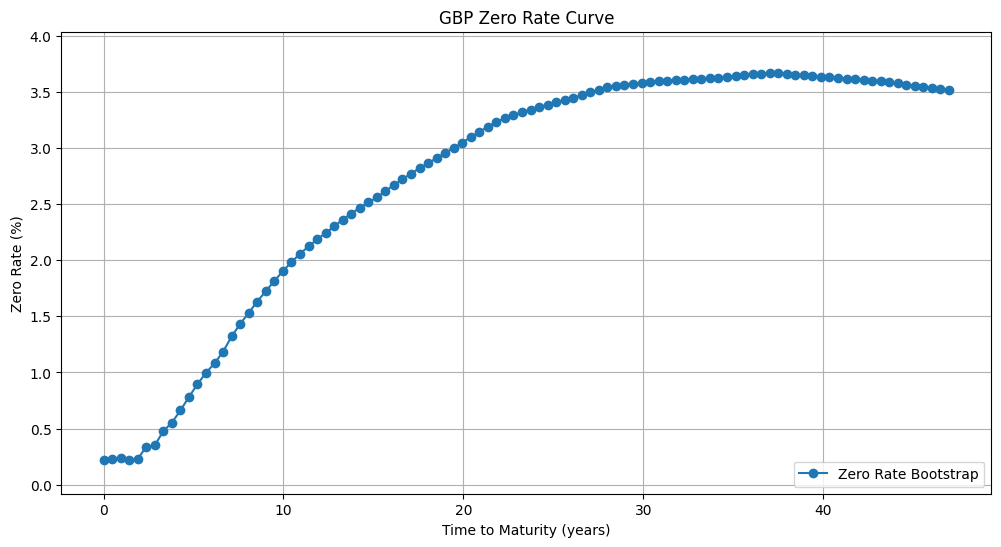

In [13]:
bondCurve.plot("GBP Zero Rate Curve")

## Forward Curve

How about the continuously compounded forwards. This gives us a detailed view on the term structure implied by the bond prices.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
times = np.linspace(0,10,2000)

In [16]:
fwds = bondCurve.fwd(times)

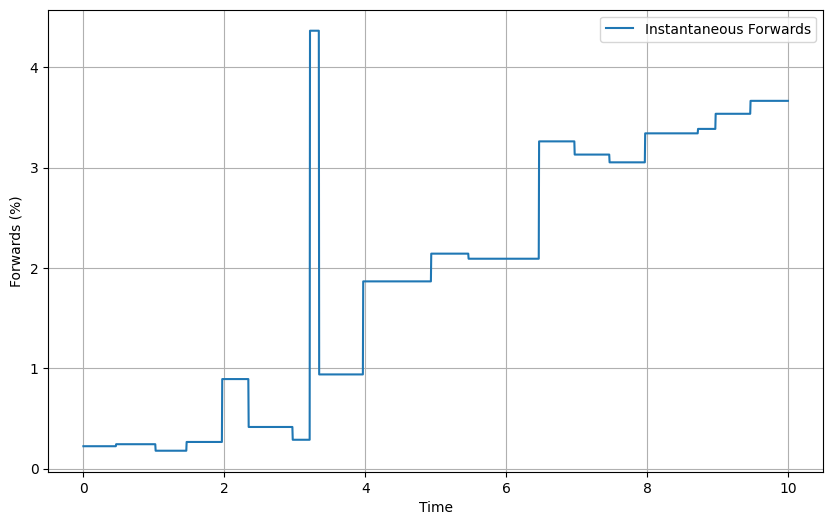

In [17]:
plt.figure(figsize=(10,6))
plt.plot(times,fwds*100, label="Instantaneous Forwards")
plt.xlabel("Time")
plt.ylabel("Forwards (%)")
plt.legend()
plt.grid()

Looks like there is some anomaly or mispricing around 3 years. As it does not last for long, it is probably not significant. 

Copyright (c) 2019, Dominic O'Kane 